# Step 1:  Load and bin microscopy fluorescent gradient data for HQNO 

This notebook analyzes HQNO gradient microscopy data by:
1. Loading raw microscopy data and filtering for wild-type (wt) samples
2. Background correcting using median intensity of lowest 1% of cell per replicate
3. Spatially binning the data on x,y coordinates (new: manual bins of 1.5um fixed size)
4. Plotting median GFP intensity profiles across distance for all chambers and replicates
5. Saving the processed data for downstream analysis

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import json

def calculate_control_bg_value(group):
    """Calculate median of lowest 1% intensity values within control group"""
    n_points = len(group)
    n_lowest = max(1, int(np.ceil(n_points * 0.01)))  # At least 1 point
    lowest_values = group['intensity_raw_gfp'].nsmallest(n_lowest)
    return lowest_values.median()

Exported binned data points to /Users/simonvanvliet/Library/CloudStorage/Dropbox/Work/Code/Spatial Tolerance Model/2_gradient_inference_altbg/data/1_hqno_fluor_gradient_binned.csv


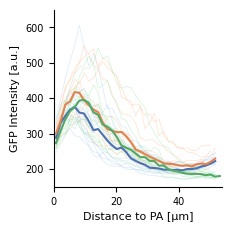

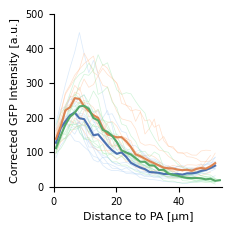

In [10]:
# --- Parameters ---

#select background correction mode, either using control experiments or using lowest 1% in each chamber individually
bg_correct_mode = 'control' # 'control' or 'chamber' 

data_path = Path.cwd().parent / 'datafiles' / 'hqno_gradient_microscopy.csv'
data_path_bg = Path.cwd().parent / '1_dose_response_curves' / 'data' / 'background_intensities.json'

pixel_to_um = 0.065

# --- Load and filter data ---
raw_df = pd.read_csv(data_path)
df = raw_df[raw_df["HQNO"] == "wt"].copy()

# load background intensity from calibration data
with open(data_path_bg, 'r') as f:
    background_values = json.load(f)
bg_value = background_values['HQNO']['bg_value']

if bg_correct_mode == 'chamber':
    # Calculate background values per replicate using lowest 1% intensities
    control_bg_values = df.groupby('replicate')[df.columns].apply(calculate_control_bg_value).reset_index()
    control_bg_values.columns = ['replicate', 'bg_value']

    # Merge background values back to main dataframe
    df = df.merge(control_bg_values, on='replicate', how='left')
    df['corrected_intensity'] = df['intensity_raw_gfp'] - df['bg_value']

elif bg_correct_mode == 'control':
    # Use background value of control calibration data
    df['corrected_intensity'] = df['intensity_raw_gfp'] - bg_value
else:
    raise ValueError("Invalid bg_correct_mode. Choose 'control' or 'chamber'.")

# --- Convert to micrometers ---
df['x_um'] = df['x'] * pixel_to_um
df['y_um'] = df['y'] * pixel_to_um

# --- Define manual bins (1.5um fixed size) ---
manual_x_bins = np.linspace(0, 49.5, 34)
manual_y_bins = np.linspace(0, 54, 37)
num_x_bins = len(manual_x_bins) - 1
num_y_bins = len(manual_y_bins) - 1

# --- Assign bins ---
df['x_bin'] = np.digitize(df['x_um'], manual_x_bins, right=False) - 1
df['y_bin'] = np.digitize(df['y_um'], manual_y_bins, right=False) - 1

# Clip to valid range
df['x_bin'] = df['x_bin'].clip(0, num_x_bins - 1)
df['y_bin'] = df['y_bin'].clip(0, num_y_bins - 1)

# Calculate bin centers and add to dataframe
y_bin_centers = (manual_y_bins[:-1] + manual_y_bins[1:]) / 2
x_bin_centers = (manual_x_bins[:-1] + manual_x_bins[1:]) / 2
df['y_um_center'] = y_bin_centers[df['y_bin']]

# --- Calculate median intensity per replicate, position, and y_bin ---
df_data = (df.groupby(['replicate_name', 'pos', 'y_bin'])[['intensity_raw_gfp', 'corrected_intensity'] ]
          .median()
          .reset_index()
          .rename(columns={'replicate_name': 'replicate', 'intensity_raw_gfp': 'median_intensity', 'corrected_intensity': 'corrected_intensity'}))

# Add y_um centers
df_data['y_um'] = y_bin_centers[df_data['y_bin']]

# Clean up: select only needed columns
df_data = df_data[['replicate', 'pos', 'y_bin', 'y_um', 'median_intensity', 'corrected_intensity']]

# --- Export to CSV ---
csv_path = Path.cwd() / 'data' / ('1_hqno_fluor_gradient_binned.csv')
df_data.to_csv(csv_path, index=False)
print(f"Exported binned data points to {csv_path}")

# --- Generate figure ---
final_width_in = 6 / 2.54
final_height_in = 6 / 2.54
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

pos_colors = sns.color_palette("pastel", n_colors=len(df_data['replicate'].unique()))
med_colors = sns.color_palette("deep", n_colors=len(df_data['replicate'].unique()))

fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

# Plot all individual chamber lines
sns.lineplot(
    data=df_data,
    x='y_um',
    y='median_intensity',
    hue='replicate',
    palette=pos_colors,
    estimator=None,
    units='pos',
    lw=0.5,
    alpha=0.4,
    legend=False,
    ax=ax
)

# Plot median over chambers per replicate
df_median = df_data.groupby(['replicate','y_um'])['median_intensity'].median().reset_index()
sns.lineplot(
    data=df_median,
    x='y_um',
    y='median_intensity',
    hue='replicate',
    lw=1.5,
    ax=ax,
    legend=False,
    palette=med_colors
)

ax.set_xlabel('Distance to PA [µm]', fontsize=font_size)
ax.set_ylabel('GFP Intensity [a.u.]', fontsize=font_size)
ax.tick_params(labelsize=font_size-1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, 54)
ax.set_ylim(150, 650)

plt.tight_layout()
plt.savefig(Path.cwd() / 'figures' / ('1_hqno_fluor_gradient_binned.pdf'), dpi=300, transparent=True)
plt.show()

# Plot corrected median over chambers per replicate
fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

# Plot all individual chamber lines
sns.lineplot(
    data=df_data,
    x='y_um',
    y='corrected_intensity',
    hue='replicate',
    palette=pos_colors,
    estimator=None,
    units='pos',
    lw=0.5,
    alpha=0.4,
    legend=False,
    ax=ax
)


df_median = df_data.groupby(['replicate','y_um'])['corrected_intensity'].median().reset_index()
sns.lineplot(
    data=df_median,
    x='y_um',
    y='corrected_intensity',
    hue='replicate',
    lw=1.5,
    ax=ax,
    legend=False,
    palette=med_colors
)

ax.set_xlabel('Distance to PA [µm]', fontsize=font_size)
ax.set_ylabel('Corrected GFP Intensity [a.u.]', fontsize=font_size)
ax.tick_params(labelsize=font_size-1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, 54)
ax.set_ylim(0, 500)

plt.tight_layout()
plt.savefig(Path.cwd() / 'figures' / ('1_hqno_fluor_gradient_binned_corrected.pdf'), dpi=300, transparent=True)
plt.show()

# Quality control

Check background correction treshold against 0-concentration gradient control

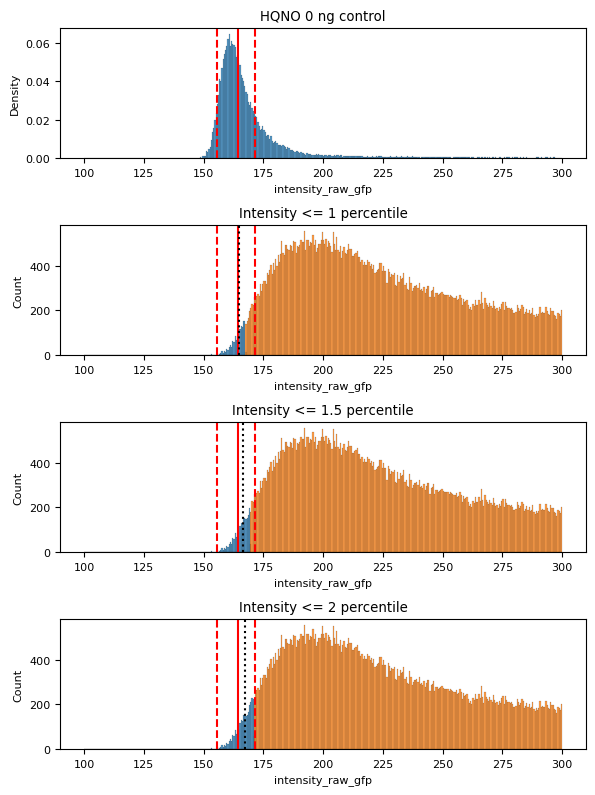

In [11]:
df_calib = pd.read_csv(Path.cwd().parent / 'datafiles/hqno_calibration_microscopy.csv')

df_h0 = df_calib[df_calib['HQNO'] == 'HQNO_0_ng'].copy()
pct = df_h0['intensity_raw_gfp'].quantile((0.05, 0.5, 0.75)).tolist()

bg_tresh = [1, 1.5, 2]
bins = np.linspace(100, 300, 401)

fig, ax = plt.subplots(len(bg_tresh)+1,1, figsize=(6,8))
sns.histplot(data=df_h0, x='intensity_raw_gfp', bins=bins, ax=ax[0], label='HQNO 0 ng', stat='density')
ax[0].set_title('HQNO 0 ng control')
ax[0].axvline(pct[0], color='red', linestyle='--')
ax[0].axvline(pct[1], color='red', linestyle='-')
ax[0].axvline(pct[2], color='red', linestyle='--')

for i, tresh in enumerate(bg_tresh):
    # get lowest tresh percentile
    df_tresh = df[df['intensity_raw_gfp'] <= df['intensity_raw_gfp'].quantile(tresh/100)]
    df_rest = df[df['intensity_raw_gfp'] > df['intensity_raw_gfp'].quantile(tresh/100)]
    sns.histplot(data=df_tresh, x='intensity_raw_gfp', bins=bins, ax=ax[i+1], label=f'<= {tresh}', stat='count')
    sns.histplot(data=df_rest, x='intensity_raw_gfp', bins=bins, ax=ax[i+1], label=f'<= {tresh}', stat='count')
    ax[i+1].set_title(f'Intensity <= {tresh} percentile')
    ax[i+1].axvline(pct[0], color='red', linestyle='--')
    ax[i+1].axvline(pct[1], color='red', linestyle='-')
    ax[i+1].axvline(pct[2], color='red', linestyle='--')
    ax[i+1].axvline(df_tresh['intensity_raw_gfp'].median(), color='black', linestyle=':')
plt.tight_layout()
plt.show()